# 시계열 데이터에서 보간법 적용 전처리

주어진 데이터에서 각 Sequence 상 Step의 개수가 모두 다르다. 각 Sequence 안에서 Step의 개수를 통일시키려고 할 때, 어떻게 해야 할까?

-> 보간법 (Interpolation)을 적용하자!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
df = pd.read_csv('dd.csv')

print(df.shape)
df.head()

(1991, 15)


,Index,Sequence,Step,Linear_vel,Q1_vel,Q2_vel,Q3_vel,Linear_pos,Q1_pos,Q2_pos,Q3_pos,Linear_tor,Q1_tor,Q2_tor,Q3_tor
0,0,0,0,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,55.0,-79.0
1,1,0,1,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,58.0,-79.0
2,2,0,2,0.0,12.0,1.0,19.0,479.336,-12.462,147.807,43.915,343.0,124.0,62.0,104.0
3,3,0,3,0.0,16.0,4.0,22.0,479.336,-12.091,147.861,43.426,343.0,124.0,80.0,127.0
4,4,0,4,0.0,16.0,4.0,22.0,479.336,-11.659,147.985,42.864,343.0,117.0,113.0,163.0


In [3]:
df.groupby('Sequence')['Step'].describe()

,count,mean,std,min,25%,50%,75%,max
Sequence,,,,,,,,
0,14.0,6.5,4.183300,0.0,3.25,6.5,9.75,13.0
1,18.0,8.5,5.338539,0.0,4.25,8.5,12.75,17.0
2,17.0,8.0,5.049752,0.0,4.00,8.0,12.00,16.0
3,9.0,4.0,2.738613,0.0,2.00,4.0,6.00,8.0
4,10.0,4.5,3.027650,0.0,2.25,4.5,6.75,9.0
...,...,...,...,...,...,...,...,...
133,13.0,6.0,3.894440,0.0,3.00,6.0,9.00,12.0
134,13.0,6.0,3.894440,0.0,3.00,6.0,9.00,12.0
135,13.0,6.0,3.894440,0.0,3.00,6.0,9.00,12.0


In [4]:
max_step = df.groupby('Sequence')['Step'].describe()['count'].max()
mean_step = df.groupby('Sequence')['Step'].describe()['count'].mean()

print(f'Sequence 별 Step 개수의 최댓값 = {max_step}')
print(f'Sequence 별 Step 개수의 평균값 = {mean_step}')

Sequence 별 Step 개수의 최댓값 = 18.0
Sequence 별 Step 개수의 평균값 = 14.427536231884059


## Sequence 별 Step 개수의 최댓값인 18 (max_step)로, 모든 Sequence의 Step 개수를 통일

In [5]:
# 모든 Sequence를 통일된 Step 개수로 보간 -> Time Series 데이터를 다루는 과정에서 '보간법' 이라는 개념이 있음 (찾아보면 좋을듯!)

dic = {}
max_step = int(df.groupby('Sequence')['Step'].describe()['count'].max())

for seq in tqdm(df['Sequence'].unique()):
    ori_len = df[df['Sequence'] == seq].shape[0] # 특정 seq의 기존 Step의 길이
    x = np.linspace(0, 1, ori_len)       # 0부터 1까지 ori_len의 길이 만큼 분할해서 데이터 만들기
    x_new = np.linspace(0, 1, max_step)  # 0부터 1까지 max_step의 길이(18) 만큼 분할해서 데이터 만들기
    
    dic[seq] = {i: [] for i in list(df.columns[3:])} 
    for col in df.columns[3:]: # Linear_vel ~ Q3_tor까지의 데이터를 적용해주기
        # max_step 만큼 늘린 개수만큼 주어진 데이터를 보간하여 늘려주기
        f = interp1d(x, df[df['Sequence'] == seq][col], kind='nearest') 
        dic[seq][col] += f(x_new).tolist()

100%|████████████████████████████████████████| 138/138 [00:00<00:00, 170.03it/s]


In [6]:
total_df = pd.DataFrame()
for key in tqdm(dic.keys()):
    dic_df = pd.DataFrame(dic[key]).reset_index()
    dic_df['Sequence'] = key
    total_df = pd.concat([total_df, dic_df], axis=0)
    
total_df.rename(columns={'index':'Step'}, inplace=True)
final_df = pd.concat([total_df['Sequence'], total_df.iloc[:, :-1]], axis=1)

print(final_df.shape)
final_df

100%|████████████████████████████████████████| 138/138 [00:00<00:00, 662.53it/s]

(2484, 14)


,Sequence,Step,Linear_vel,Q1_vel,Q2_vel,Q3_vel,Linear_pos,Q1_pos,Q2_pos,Q3_pos,Linear_tor,Q1_tor,Q2_tor,Q3_tor
0,0,0,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,55.0,-79.0
1,0,1,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,58.0,-79.0
2,0,2,0.0,12.0,1.0,19.0,479.336,-12.462,147.807,43.915,343.0,124.0,62.0,104.0
3,0,3,0.0,12.0,1.0,19.0,479.336,-12.462,147.807,43.915,343.0,124.0,62.0,104.0
4,0,4,0.0,16.0,4.0,22.0,479.336,-12.091,147.861,43.426,343.0,124.0,80.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,137,13,0.0,16.0,5.0,23.0,479.335,-8.298,148.951,38.539,342.0,121.0,107.0,119.0
14,137,14,0.0,16.0,5.0,23.0,479.335,-8.298,148.951,38.539,342.0,121.0,107.0,119.0
15,137,15,0.0,15.0,3.0,20.0,479.335,-7.879,149.080,37.962,342.0,154.0,150.0,119.0
16,137,16,0.0,15.0,3.0,20.0,479.335,-7.879,149.080,37.962,342.0,154.0,150.0,119.0


In [7]:
# 가장 처음 데이터셋의 0번째 Sequence
df[df['Sequence'] == 0]

,Index,Sequence,Step,Linear_vel,Q1_vel,Q2_vel,Q3_vel,Linear_pos,Q1_pos,Q2_pos,Q3_pos,Linear_tor,Q1_tor,Q2_tor,Q3_tor
0,0,0,0,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,55.0,-79.0
1,1,0,1,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,58.0,-79.0
2,2,0,2,0.0,12.0,1.0,19.0,479.336,-12.462,147.807,43.915,343.0,124.0,62.0,104.0
3,3,0,3,0.0,16.0,4.0,22.0,479.336,-12.091,147.861,43.426,343.0,124.0,80.0,127.0
4,4,0,4,0.0,16.0,4.0,22.0,479.336,-11.659,147.985,42.864,343.0,117.0,113.0,163.0
5,5,0,5,0.0,17.0,4.0,21.0,479.336,-9.643,148.564,40.288,343.0,114.0,112.0,156.0
6,6,0,6,0.0,16.0,5.0,22.0,479.336,-9.201,148.691,39.704,343.0,113.0,103.0,144.0
7,7,0,7,0.0,16.0,4.0,21.0,479.336,-8.762,148.825,39.128,343.0,117.0,110.0,126.0
8,8,0,8,0.0,16.0,6.0,22.0,479.336,-8.319,148.954,38.553,341.0,101.0,64.0,151.0
9,9,0,9,0.0,15.0,3.0,20.0,479.336,-7.876,149.101,37.988,343.0,149.0,102.0,130.0


In [8]:
# 보간법을 취한 데이터셋의 0번째 Sequence
final_df[final_df['Sequence'] == 0]

,Sequence,Step,Linear_vel,Q1_vel,Q2_vel,Q3_vel,Linear_pos,Q1_pos,Q2_pos,Q3_pos,Linear_tor,Q1_tor,Q2_tor,Q3_tor
0,0,0,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,55.0,-79.0
1,0,1,0.0,0.0,0.0,0.0,479.336,-12.462,147.806,43.922,343.0,3.0,58.0,-79.0
2,0,2,0.0,12.0,1.0,19.0,479.336,-12.462,147.807,43.915,343.0,124.0,62.0,104.0
3,0,3,0.0,12.0,1.0,19.0,479.336,-12.462,147.807,43.915,343.0,124.0,62.0,104.0
4,0,4,0.0,16.0,4.0,22.0,479.336,-12.091,147.861,43.426,343.0,124.0,80.0,127.0
5,0,5,0.0,16.0,4.0,22.0,479.336,-11.659,147.985,42.864,343.0,117.0,113.0,163.0
6,0,6,0.0,17.0,4.0,21.0,479.336,-9.643,148.564,40.288,343.0,114.0,112.0,156.0
7,0,7,0.0,17.0,4.0,21.0,479.336,-9.643,148.564,40.288,343.0,114.0,112.0,156.0
8,0,8,0.0,16.0,5.0,22.0,479.336,-9.201,148.691,39.704,343.0,113.0,103.0,144.0
9,0,9,0.0,16.0,4.0,21.0,479.336,-8.762,148.825,39.128,343.0,117.0,110.0,126.0


In [9]:
# 0부터 17번째 Step의 모든 개수가 기존 Sequence 개수인 138로 맞춰진 것 확인! -> 성공!!
final_df.groupby('Step').count()

,Sequence,Linear_vel,Q1_vel,Q2_vel,Q3_vel,Linear_pos,Q1_pos,Q2_pos,Q3_pos,Linear_tor,Q1_tor,Q2_tor,Q3_tor
Step,,,,,,,,,,,,,
0,138,138,138,138,138,138,138,138,138,138,138,138,138
1,138,138,138,138,138,138,138,138,138,138,138,138,138
2,138,138,138,138,138,138,138,138,138,138,138,138,138
3,138,138,138,138,138,138,138,138,138,138,138,138,138
4,138,138,138,138,138,138,138,138,138,138,138,138,138
5,138,138,138,138,138,138,138,138,138,138,138,138,138
6,138,138,138,138,138,138,138,138,138,138,138,138,138
7,138,138,138,138,138,138,138,138,138,138,138,138,138
8,138,138,138,138,138,138,138,138,138,138,138,138,138


In [10]:
mean_df = final_df.groupby('Step').mean().iloc[:, 1:]
mean_df

,Linear_vel,Q1_vel,Q2_vel,Q3_vel,Linear_pos,Q1_pos,Q2_pos,Q3_pos,Linear_tor,Q1_tor,Q2_tor,Q3_tor
Step,,,,,,,,,,,,
0,0.0,0.108696,0.000000,0.007246,479.335007,-12.421420,147.806790,43.916333,342.007246,-55.521739,55.384058,-70.536232
1,0.0,0.000000,0.000000,0.000000,479.335007,-12.423087,147.806536,43.917623,341.949275,-57.862319,55.065217,-82.115942
2,0.0,5.637681,0.579710,11.326087,479.335007,-12.422993,147.807123,43.914377,342.123188,51.688406,53.840580,32.057971
3,0.0,11.362319,2.050725,19.007246,479.335007,-12.297290,147.830109,43.728065,341.992754,111.318841,62.768116,106.376812
4,0.0,14.775362,3.557971,20.746377,479.335007,-11.820652,147.950051,43.091138,342.260870,116.289855,74.913043,133.434783
5,0.0,15.644928,3.956522,21.195652,479.335007,-11.356478,148.078826,42.490942,342.166667,111.630435,82.101449,142.007246
6,0.0,16.536232,4.173913,20.811594,479.335007,-10.982138,148.179609,42.005833,341.963768,109.391304,90.905797,147.014493
7,0.0,16.333333,4.442029,21.659420,479.335007,-10.691014,148.263703,41.634986,341.985507,113.384058,93.840580,149.891304
8,0.0,16.630435,4.630435,20.768116,479.335007,-10.187696,148.406130,40.962971,342.217391,114.500000,98.623188,150.304348


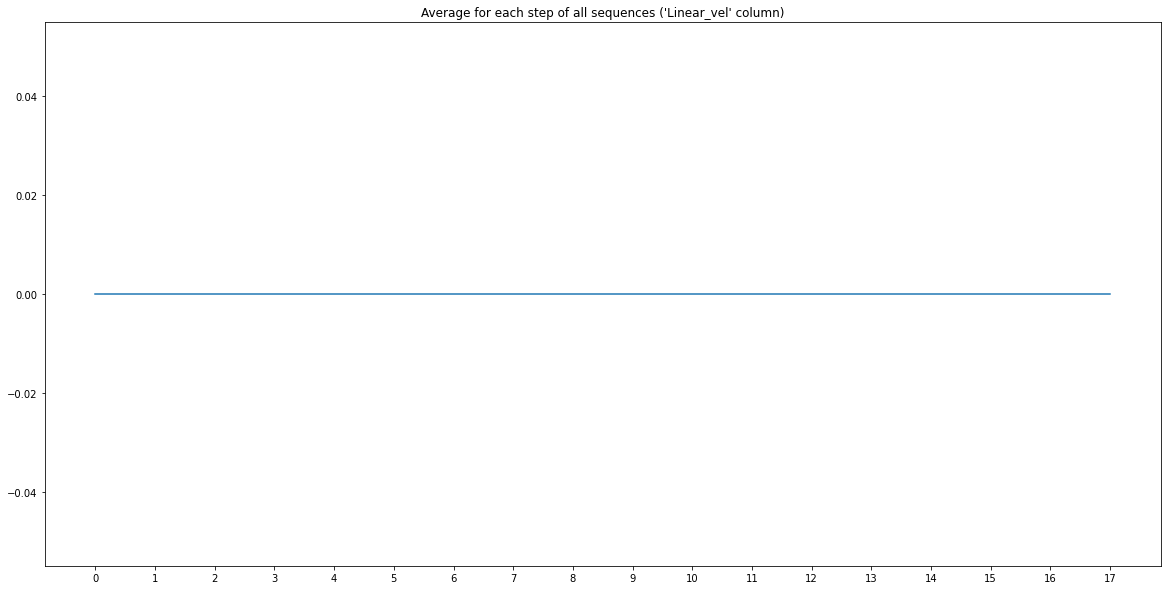

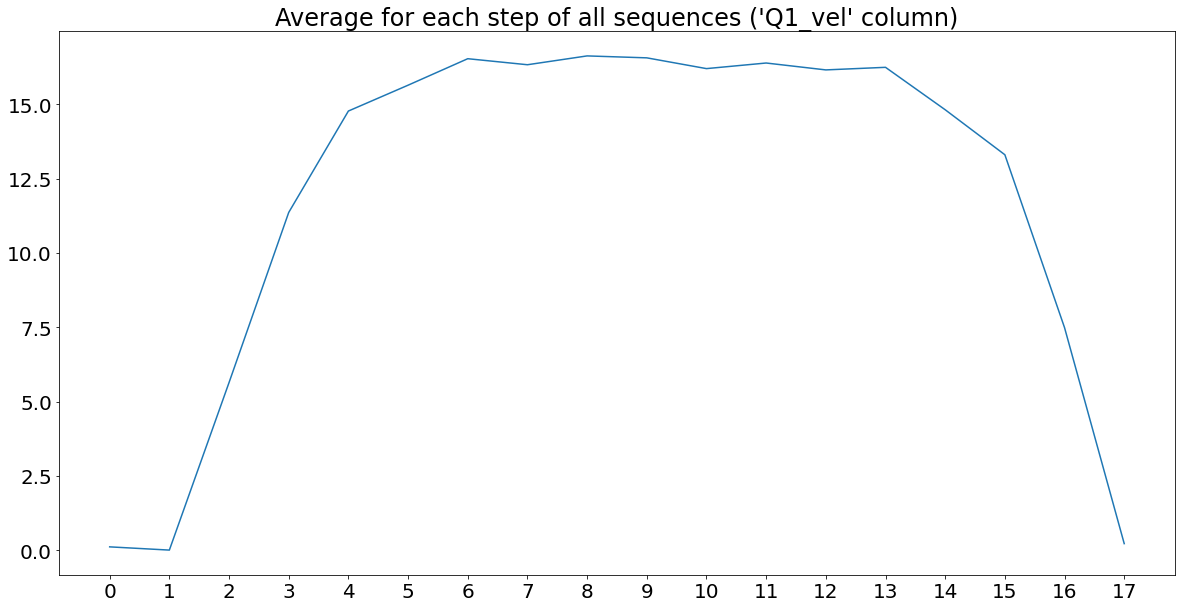

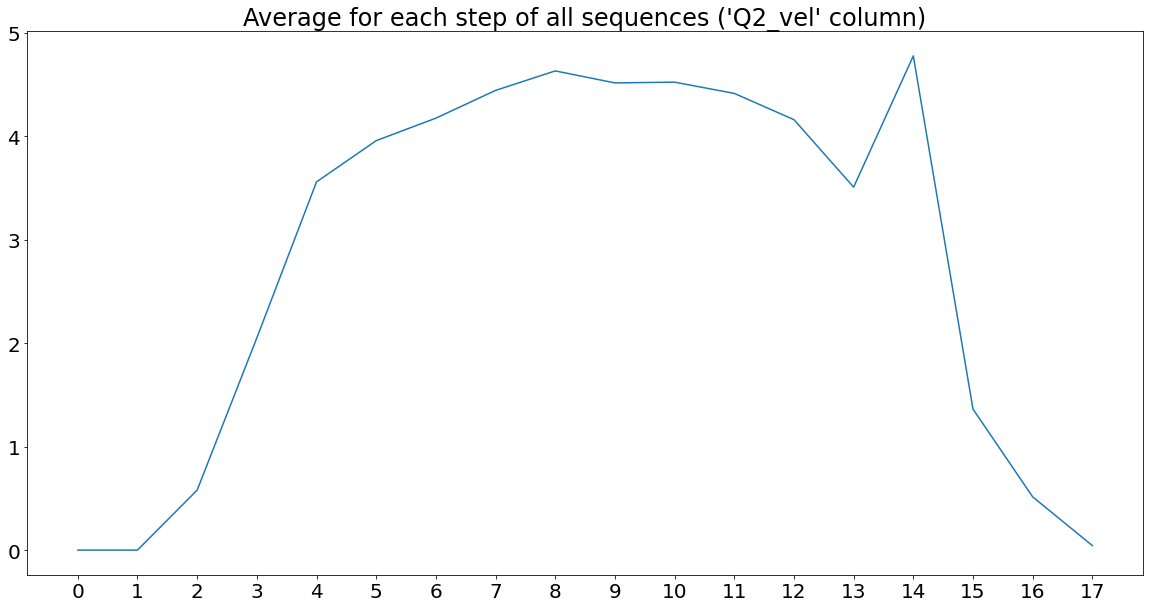

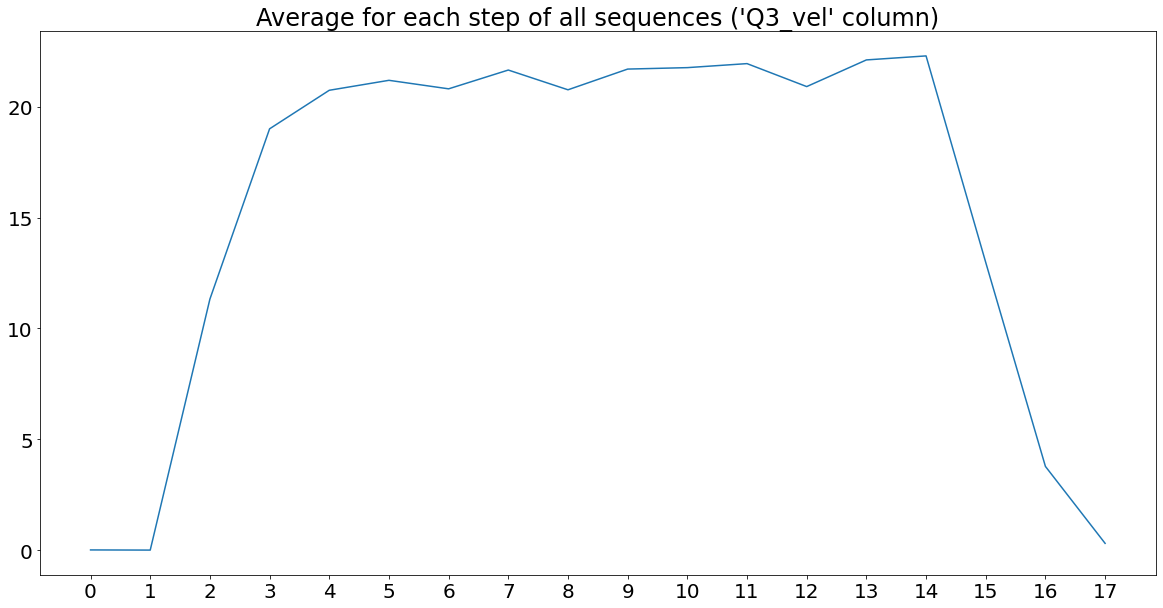

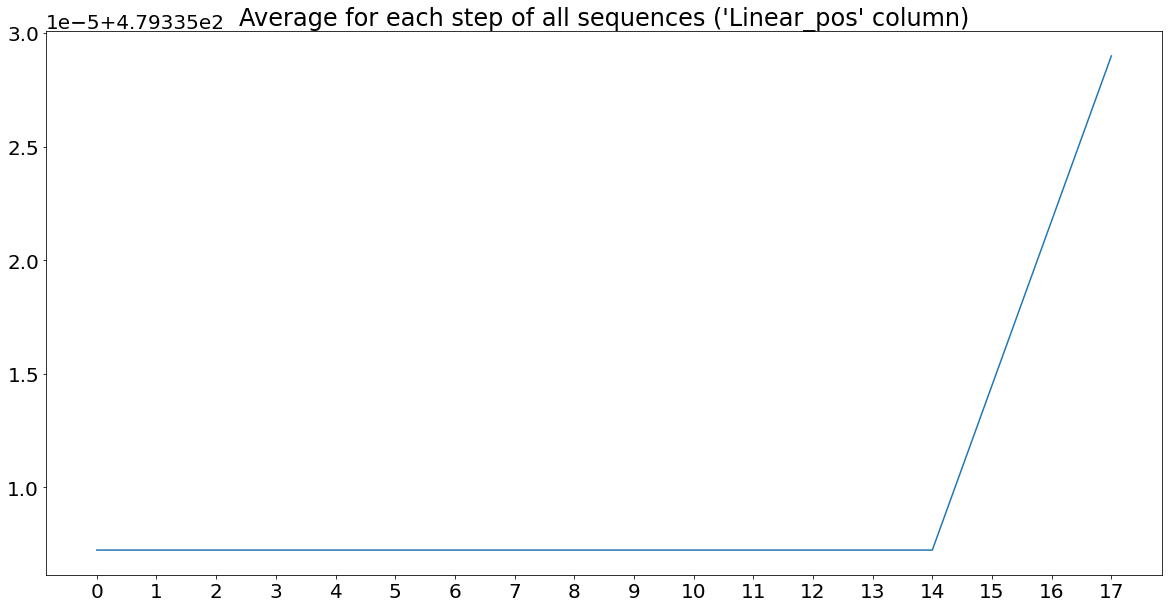

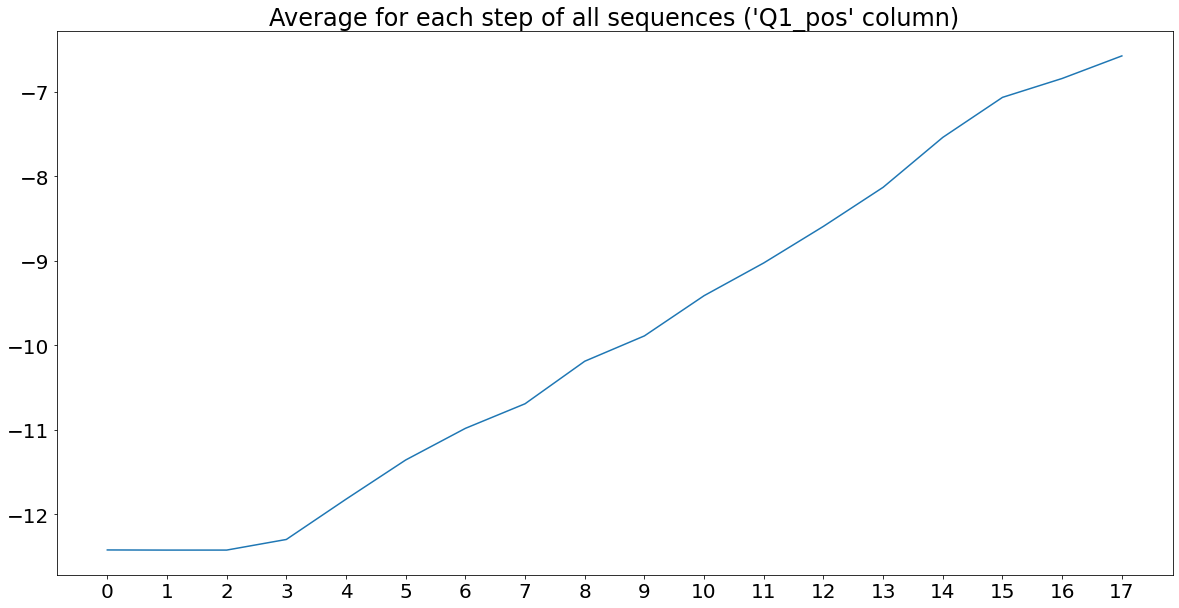

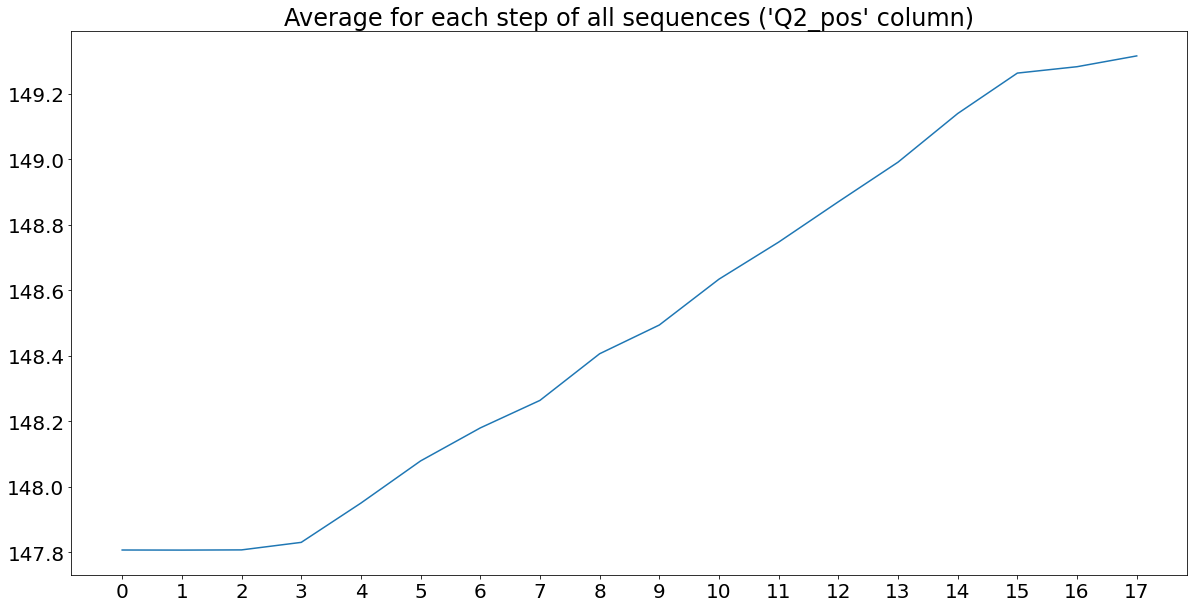

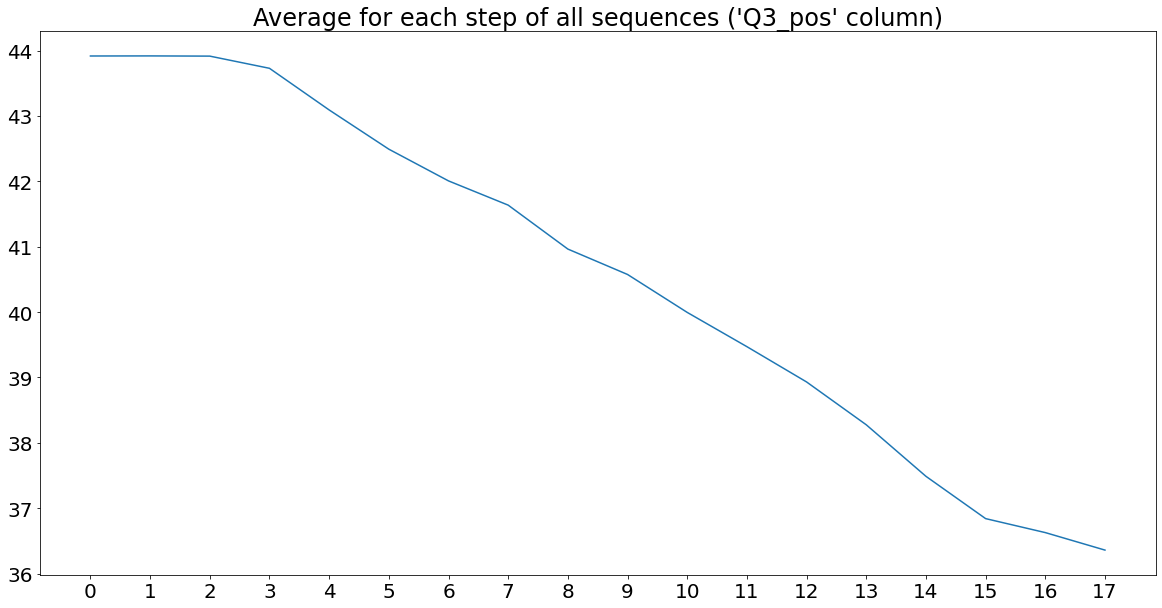

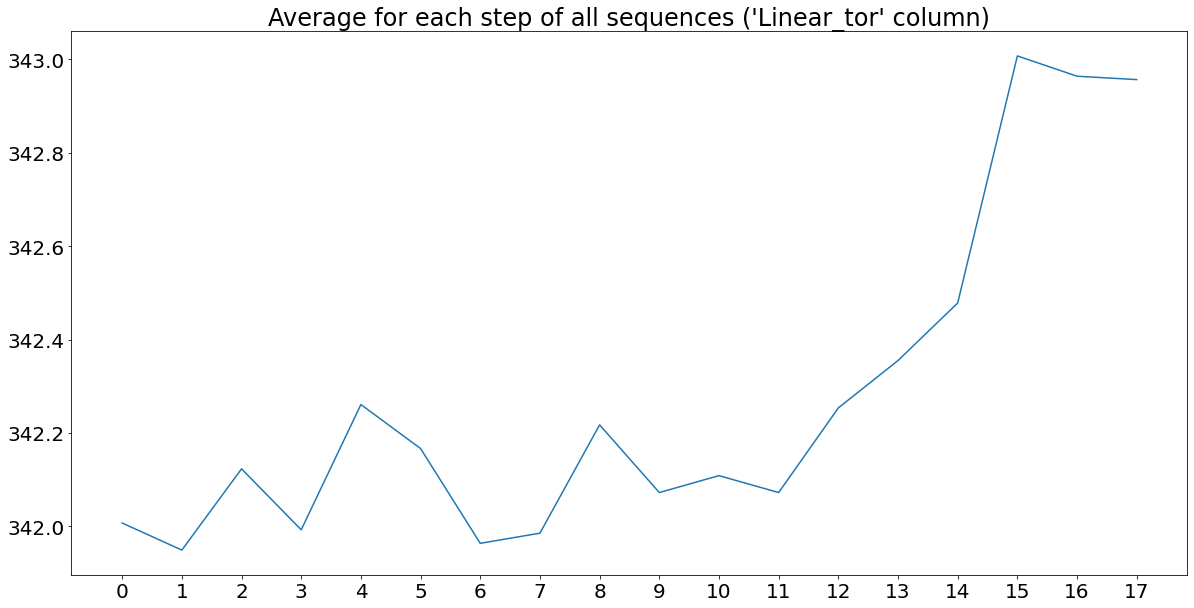

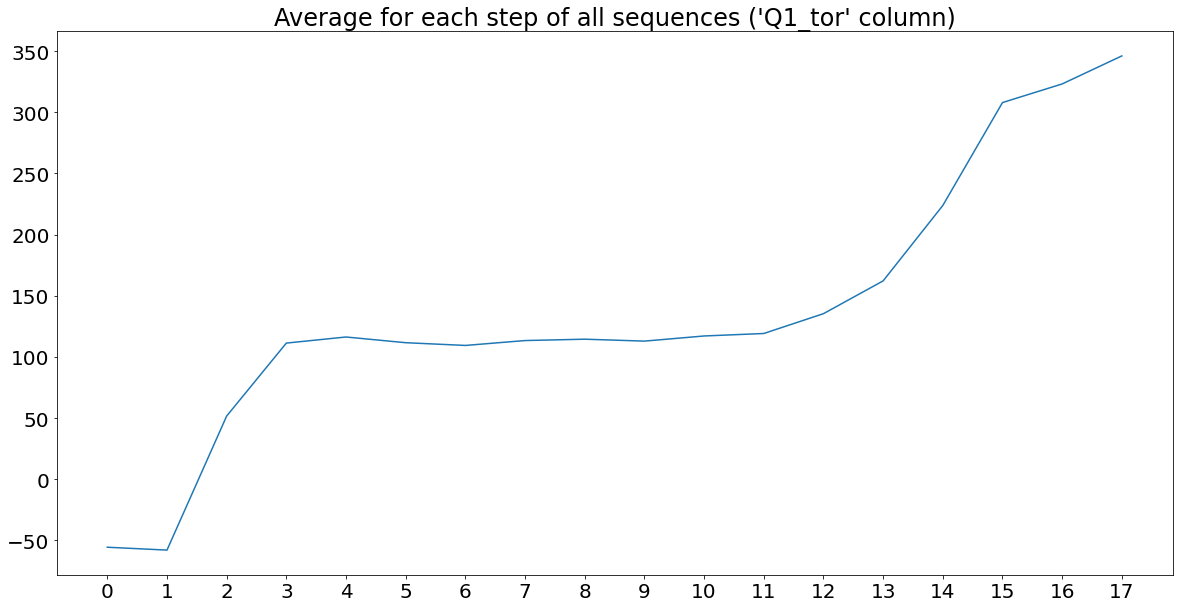

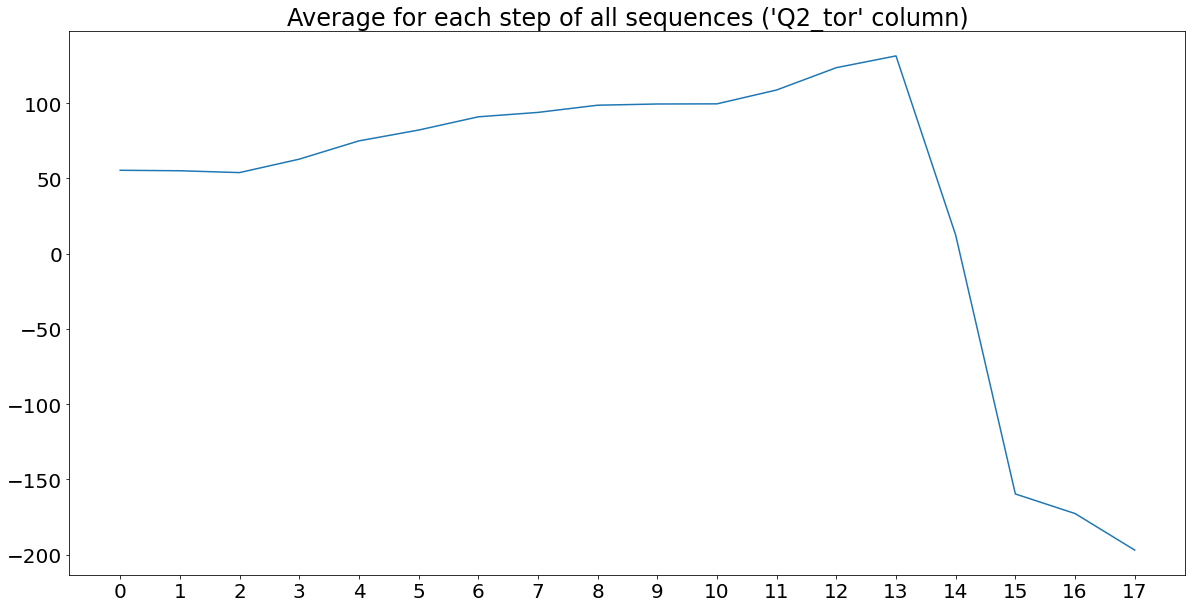

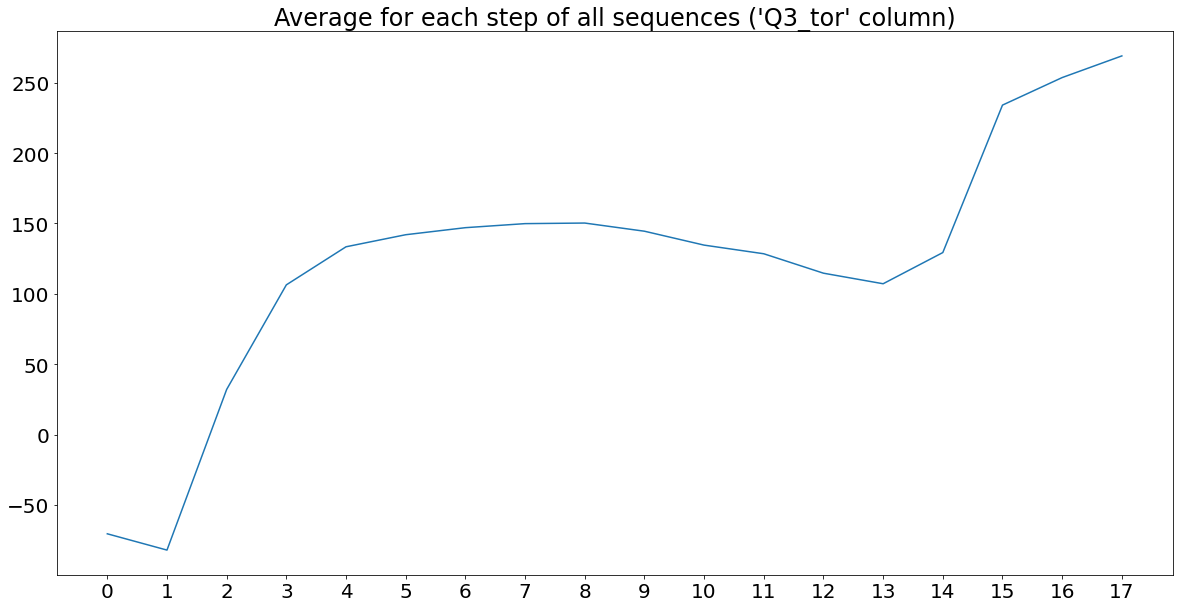

In [11]:
for col in mean_df.columns:
    plt.rc('font', size=20) 
    plt.figure(figsize=(20, 10))
    plt_df = mean_df[col].reset_index()
    plt.plot(plt_df[col])
    plt.xticks(plt_df['Step'])
    plt.title(f"Average for each step of all sequences ('{col}' column)")
    plt.show()